In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample, pyro_method
import pyro.distributions as dist
import pyro.poutine as poutine

from src.modules.config import read_config
from src.modules.datageneration import load_data, data_functions

from src import generate
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import src.tyxe as tyxe

import seaborn as sns

/Home/siv31/tak011/.conda/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_DIR = "./configs/bnn-vs-nn"
PROFILE = "model-fixed"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]
DEVICE = config["DEVICE"]

In [5]:
# make plots dir
if not os.path.exists(BASE_DIR + "/plots"):
    os.makedirs(BASE_DIR + "/plots")


sns.set_style("whitegrid", {'axes.edgecolor' : '.1', 'axes.linewidth': 0.3, 'xtick.bottom': True,
    'ytick.left': True,
})

In [6]:
x1 = torch.rand(20, 1) * 15.0 - 18.2
x2 = torch.rand(20, 1) * 15.4 + 4.2
x = torch.cat([x1, x2])
sigma = 0.2
noise = torch.normal(mean=torch.full_like(x, 0.), std=sigma)
y = 0.01*x + x.mul(0.2).add(-0.2).sin().mul(0.7) + noise

x_func = torch.linspace(-30, 30, 401).unsqueeze(-1)

y_func = 0.01*x_func + x_func.mul(0.2).add(-0.2).sin().mul(0.7)

In [7]:
dataset = data.TensorDataset(x, y)
dataloader = data.DataLoader(dataset, batch_size=len(x))

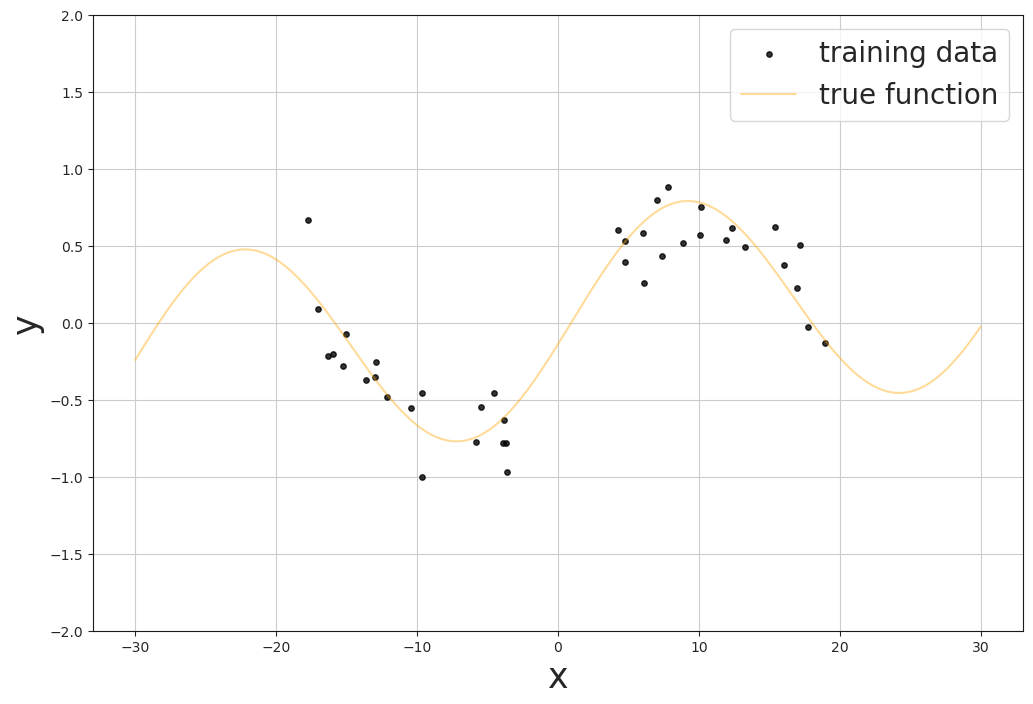

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x.squeeze(), y, s=15, color="black", alpha=0.8, label="training data")
plt.plot(x_func.squeeze(), y_func, color="orange", alpha=0.4, label="true function")
plt.ylim(-2, 2)

plt.legend( fontsize=20)
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.savefig(f"{BASE_DIR}/plots/data.svg", dpi=1200)
plt.show()

In [9]:
"""NN"""

'NN'

In [10]:
net = nn.Sequential(nn.Linear(1, 64), nn.ReLU(), nn.Linear(64, 1)).to(DEVICE)
#net = nn.Linear(1, 1).to(DEVICE)
x, y = x.to(DEVICE), y.to(DEVICE)
optim = torch.optim.Adam(net.parameters(), 1e-4)
for i in range(5000):
    optim.zero_grad()
    net(x).sub(y).pow(2).mean().backward()
    optim.step()
    if i % 1000 == 0:
        print(f"Epoch: {i}")

Epoch: 0
Epoch: 1000
Epoch: 2000
Epoch: 3000
Epoch: 4000


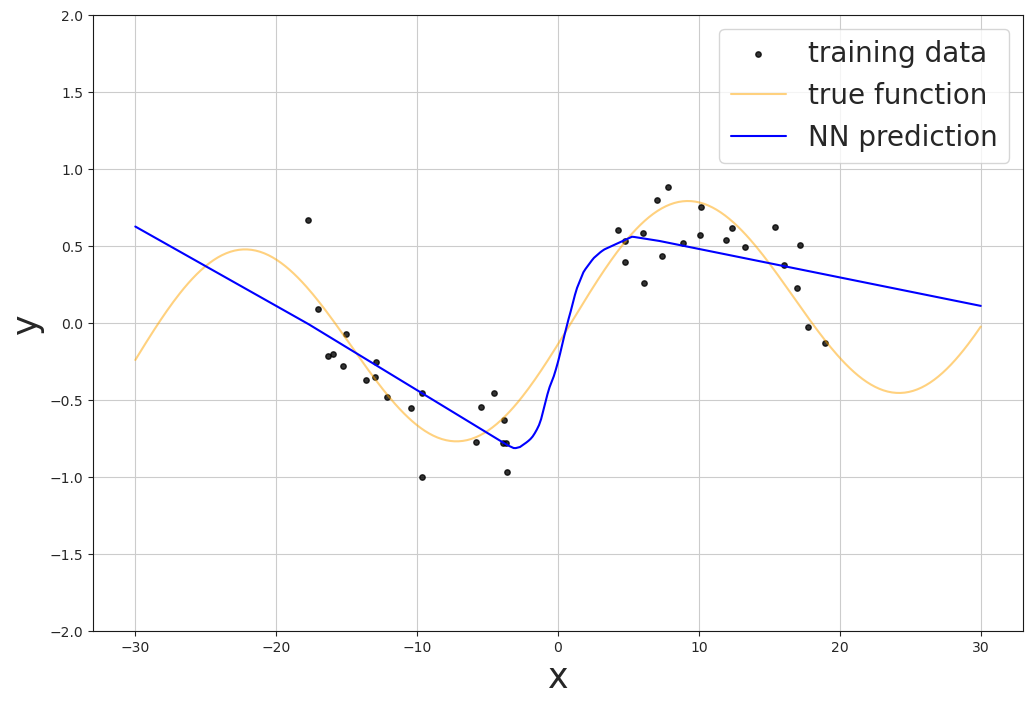

In [11]:
preds = net(x_func.to(DEVICE)).detach().cpu()
x, y = x.cpu(), y.cpu()

fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x.squeeze(), y, s=15, color="black", alpha=0.8, label="training data")
plt.plot(x_func.squeeze(), y_func, color="orange", alpha=0.5, label="true function")
plt.plot(x_func, preds, color="blue", label="NN prediction")
plt.ylim(-2, 2)
plt.legend( fontsize=20)
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.savefig(f"{BASE_DIR}/plots/nn.svg", dpi=1200)
plt.show()


In [12]:
"""SVI"""

'SVI'

In [13]:
net = nn.Sequential(nn.Linear(1, 64), nn.ReLU(), nn.Linear(64, 1))
#net = nn.Linear(1, 1)
prior = tyxe.priors.IIDPrior(dist.Normal(0, 0.5))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=dist.Gamma(1.0, 1.0))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=torch.tensor(0.1))
likelihood_guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
#likelihood_guide_builder = None

guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.bnn.VariationalBNN(net, prior, obs_model, guide_builder, likelihood_guide_builder=likelihood_guide_builder)

In [14]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-4})
elbos = []
def callback(bnn, i, e):
    if i % 1000 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(dataloader, optim, 5000, callback=callback, num_particles=10)

epoch: 0 | elbo: 7610.831103515625
epoch: 1000 | elbo: 959.934912109375
epoch: 2000 | elbo: 848.4861816406251
epoch: 3000 | elbo: 759.7144836425781
epoch: 4000 | elbo: 721.697265625


In [15]:
test_sort = torch.argsort(x_func.squeeze())
preds = bnn.predict(x_func[test_sort], num_predictions=1000, aggregate=True)

In [16]:
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

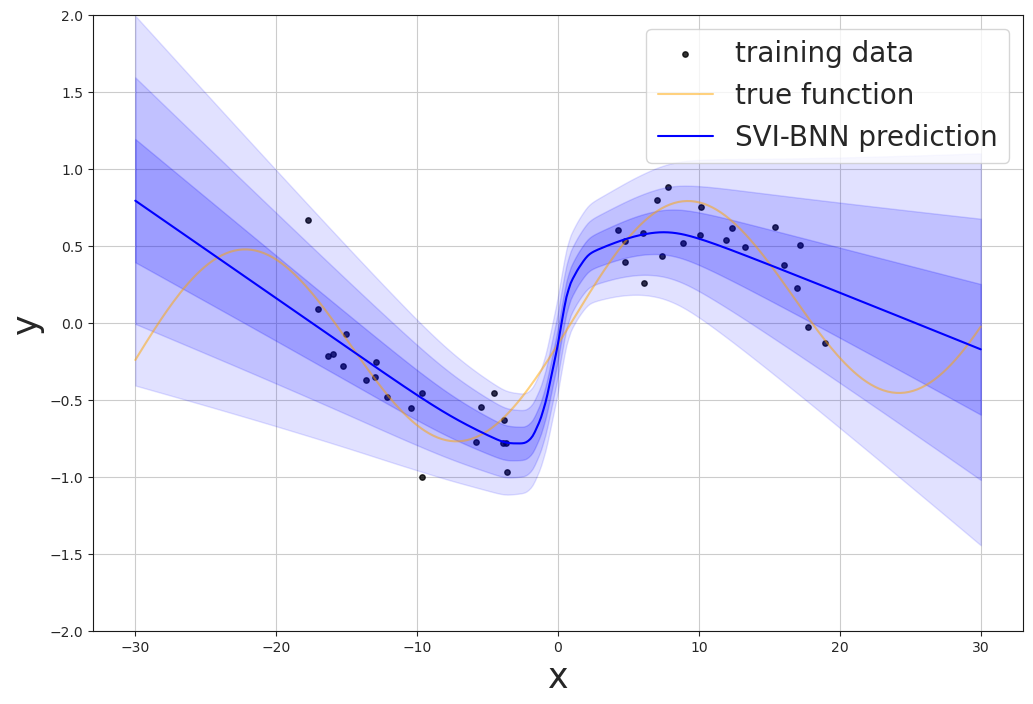

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x.squeeze(), y, s=15, color="black", alpha=0.8, label="training data")
plt.plot(x_func.squeeze(), y_func, color="orange", alpha=0.5, label="true function")
plt.plot(x_func, means, color="blue", label="SVI-BNN prediction")
for c in range(1, 4):
    plt.fill_between(x_func.squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.0/(0.4 + (0.15*c))) * 0.1, color="blue")





plt.ylim(-2, 2)
plt.legend( fontsize=20)
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.savefig(f"{BASE_DIR}/plots/bnn.svg", dpi=1200)
plt.show()

In [18]:
"""MCMC BNN"""

'MCMC BNN'

In [19]:
net = nn.Sequential(nn.Linear(1, 64), nn.ReLU(), nn.Linear(64, 1))
#net = nn.Linear(1, 1)
prior = tyxe.priors.IIDPrior(dist.Normal(0, 0.5))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=torch.tensor(0.1))

kernel = pyro.infer.mcmc.NUTS

bnn = tyxe.MCMC_BNN(net, prior, obs_model, kernel)

In [20]:
pyro.clear_param_store()

bnn.fit(dataloader, num_samples=1000, warmup_steps=200)

Sample: 100%|████████████████████████████████████████| 1200/1200 [32:25,  1.62s/it, step size=1.04e-03, acc. prob=0.878]                                                                                                                         


In [21]:
test_sort = torch.argsort(x_func.squeeze())
preds = bnn.predict(x_func[test_sort], num_predictions=1000, aggregate=True)

In [22]:
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()
print("Hællæ")

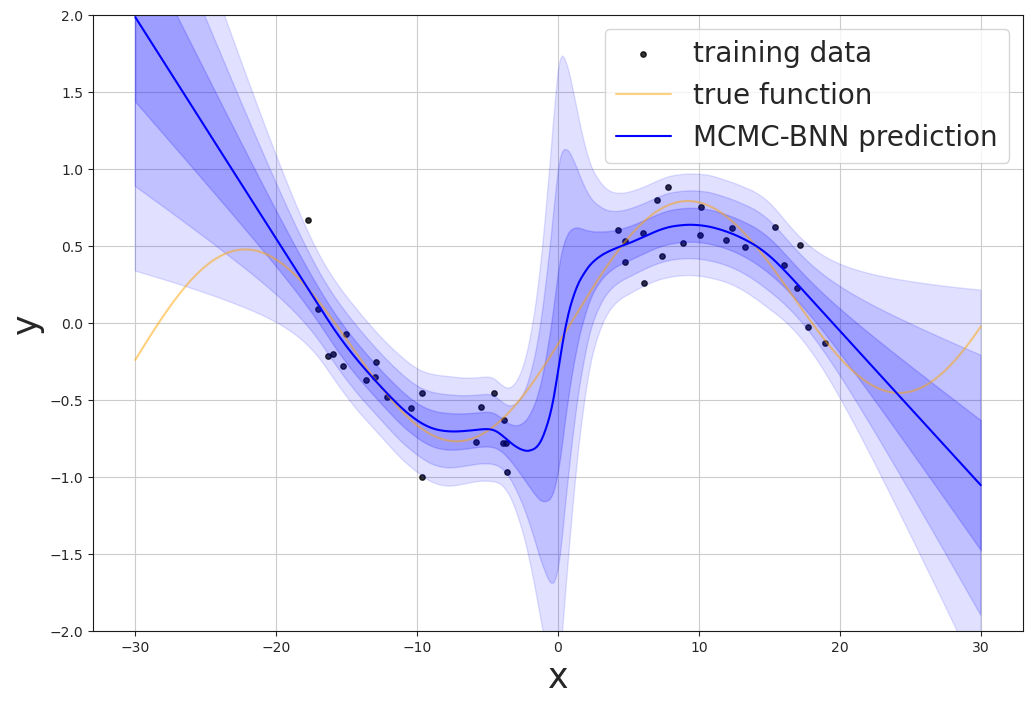

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x.squeeze(), y, s=15, color="black", alpha=0.8, label="training data")
plt.plot(x_func.squeeze(), y_func, color="orange", alpha=0.5, label="true function")
plt.plot(x_func, means, color="blue", label="MCMC-BNN prediction")
for c in range(1, 4):
    plt.fill_between(x_func.squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.0/(0.4 + (0.15*c))) * 0.1, color="blue")





plt.ylim(-2, 2)
plt.legend( fontsize=20)
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.savefig(f"{BASE_DIR}/plots/mcmc-bnn.svg", dpi=1200, format="svg")
plt.show()

In [ ]:
print("Hællæ")